[Table of Contents](00.00-Learning-ML.ipynb#Table-of-Contents) &bull; [&larr; *Chapter 2.02 - Naive Bayes*](02.02-Naive-Bayes.ipynb) &bull; [*Chapter 2.04 - Decision Trees* &rarr;](02.04-Decision-Trees.ipynb)

---

# Chapter 2.03 - k-Nearest Neighbours

k-Nearest Neighbours, or kNN, is an algorithm that uses the *distance* between the feature values to find a specified number of the "closest" observations (as measured by having a small distance). Predictions are assigned by selecting the majority class from the set of closest observations, or alternatively probabilities estimated using the proportions of classes in the same set.

The number of closest observations to consider can be changed for each model. This number is denoted (known as) "k" - hence the algorithm's name *k-Nearest Neighbours*.

kNN models, unlike Naive Bayes, actually do very little work during training. The model essentially stores an unprocessed copy of the input observations (X) and their corresponding outputs (y). To make predictions,  the new input X is compared (by distance) to all of the stored observations. This is done for every prediction, and hence producing predictions takes far more computation time per prediction, especially when the number of observations increases.

The benefit of KNN is that relationships between each of the features are implicitly considered, so we can potentially achieve a better performing model.

## Measuring distance

kNN works by computing a distance metric between each labelled observation (X values with a corresponding y value) and an unlabelled observation (for which we are trying to predict yhat). This means that we need to be able to measure the distance between values of a feature. For example, if the feature is 'age', and we have 3 observations of 14, 22 and 35, the absolute distance between 14 and 22 is 8, 14 and 35 is 21, 22 and 35 is 13.

This is straightforward when our feature inputs are numeric or binary. When the inputs are categorical, then either a custom distance function must be used (such as Hamming distance, which measures the number of characters different in two strings), or the data must be transformed or *encoded*.

A common encoding method is to take a categorical feature with n values, and split it into n binary features where one associated with the categorical value is true (or 1) and the rest false (or 0). This particular method is known as *one-hot encoding*.

## Implementing kNN

In the last chapter, we learned how to split our data for training and testing in order to properly measure the performance of our models. Now we will generate some data for classification, split it appropriately and train a kNN classifier with k (`n_neighbors`) set to 4. Previously, we also discovered how useful the receiver operating characteristic (ROC) curve was for determining performance. We will plot our results as an ROC curve.

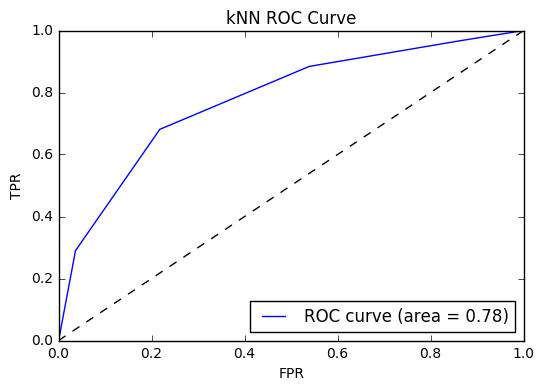

In [42]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

# create some data and split into training and test sets
X, y = make_classification(n_samples=1000, n_classes=2, n_features=500, n_informative=250)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# fit kNN classifier and make predictions
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
predictions = knn.predict_proba(X_test)

# calculate AUC, should be much better than our previous dummy classifiers!
FPR, TPR, thresholds = metrics.roc_curve(y_test, predictions[:,1])
roc_auc = metrics.auc(FPR,TPR)

# plot our data 
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('kNN ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right");

## Optimising k

How do we know what value of k is best? This will depend on the your exact problem and teh data. We can find an optimal k for classification performance by maximising AUC. To find out for our test, we will compute kNN for k values of 1 to 100, and compare the results to determine when AUC peaks.

Once we have found the optimal k, we can use `KNeighborsClassifier` with that value of k to make the best predictions when the value of y is unknown.

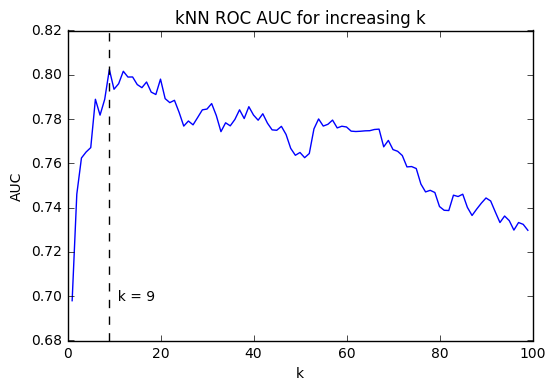

In [80]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

# create some data and split into training and test sets
X, y = make_classification(n_samples=1000, n_classes=2, n_features=500, n_informative=250)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

px = []
py = []

for k in range(1,100):

    # fit kNN classifier and make predictions
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict_proba(X_test)

    # calculate AUC, should be much better than our previous dummy classifiers!
    FPR, TPR, thresholds = metrics.roc_curve(y_test, predictions[:,1])
    roc_auc = metrics.auc(FPR,TPR)
    
    px.append(k)
    py.append(roc_auc)
    
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(px,py)
plt.axvline(x=px[py.index(max(py))], color='black', linestyle='--')
plt.text(px[py.index(max(py))], min(py), '  k = %d' % px[py.index(max(py))], rotation= 0)
plt.title('kNN ROC AUC for increasing k')
plt.xlabel('k')
plt.ylabel('AUC');

For the example above, we can clearly see when AUC peaks and the corresponding value of k.

## Performance with increasing observations

At the beginning of this chapter, we noted that kNN performance will decline when the number of observations increases. To test this, we're going to time a number of executions to find out exactly what happens.

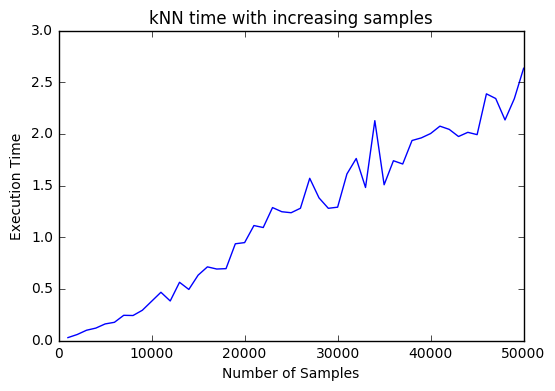

In [96]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

px = []
py = []

for samples in range(1000,51000,1000):
    
    # create some data and split into training and test sets
    X, y = make_classification(n_samples=samples, n_classes=2, n_features=50, n_informative=25)
    ts = 400/samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

    # fit kNN classifier and make predictions
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(X_train, y_train)
    
    # this is some Jupyter magic that allows us to capture execution timing
    # this might take a while to run
    result = %timeit -o -q knn.predict_proba(X_test)
    
    px.append(samples)
    py.append(result.best)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(px,py)
plt.title('kNN time with increasing samples')
plt.xlabel('Number of training samples')
plt.ylabel('Execution time (400 predictions)');

From the example above, we can see that as the number of samples increases, the execution time to score 400 new observations increases approximately linearly.

## What next?

Now it's time to explore another type of algorithm - which can provide the power of inter-feature relationships for prediction, with a more complex training step that results in a much faster prediction execution time.

---

[Table of Contents](00.00-Learning-ML.ipynb#Table-of-Contents) &bull; [&larr; *Chapter 2.02 - Naive Bayes*](02.02-Naive-Bayes.ipynb) &bull; [*Chapter 2.04 - Decision Trees* &rarr;](02.04-Decision-Trees.ipynb)